In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import Subset

from augment import CutMix


print(torch.cuda.is_available())

True


## Augmentations

In [12]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './images'
full_dataset = datasets.ImageFolder(data_dir) 

indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

# the values for the split are found manually to have 150 pictures of each class in training
split = int(0.74 * len(full_dataset))
train_indices, val_indices = indices[:split-1], indices[split-1:]

train_dataset = Subset(datasets.ImageFolder(data_dir, transform=data_transforms["train"]), train_indices)
val_dataset   = Subset(datasets.ImageFolder(data_dir, transform=data_transforms["val"]), val_indices)


N_train = len(train_dataset)
N_val = len(val_dataset)

print(f"Training set size: {N_train} images")
print(f"Validation set size: {N_val} images")


cutmix_transform = CutMix()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Training set size: 300 images
Validation set size: 107 images


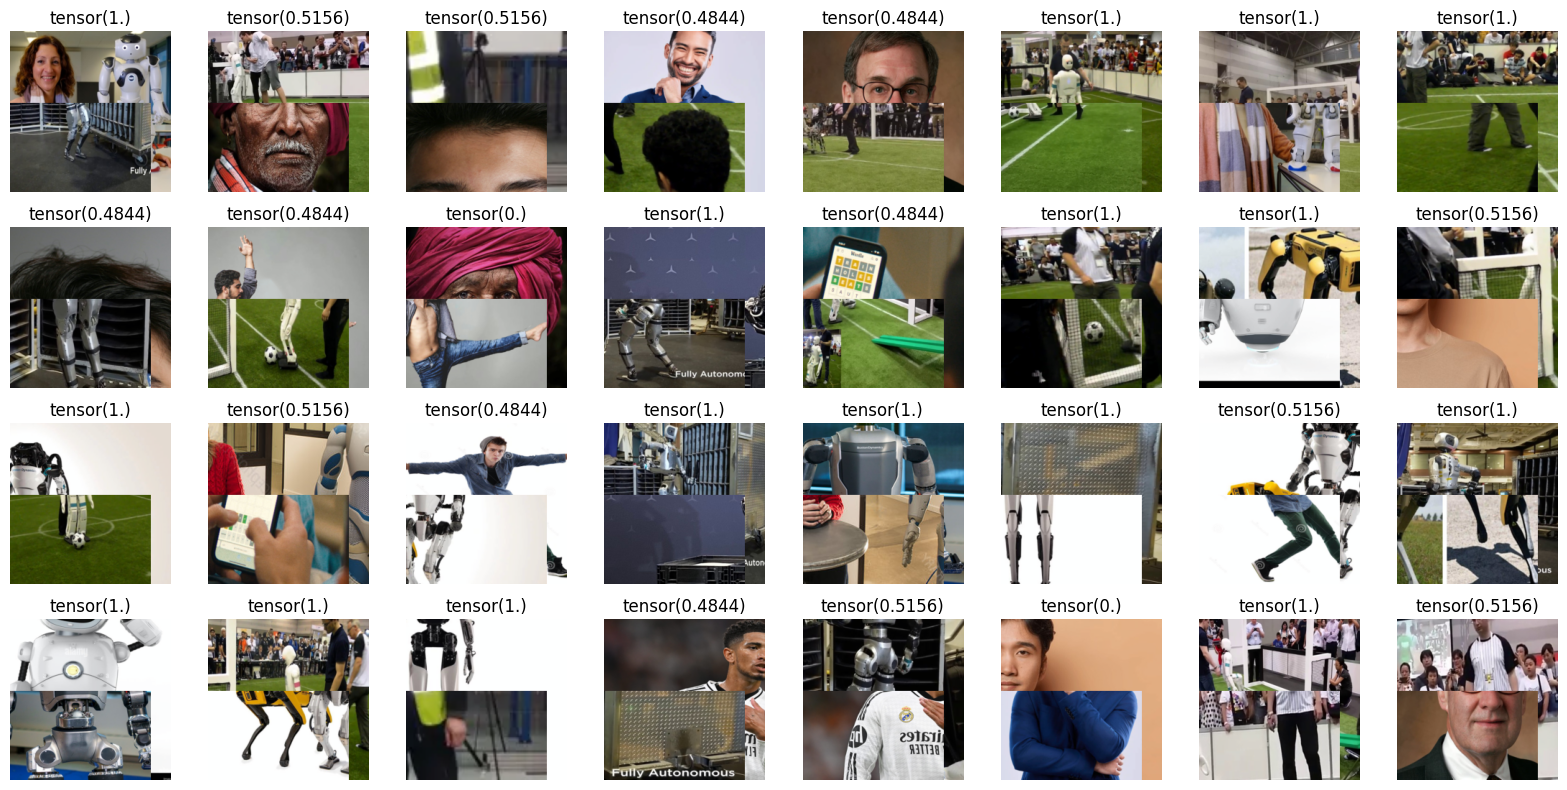

In [13]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean  # IMPORTANT! If you normalize imgs in the DataLoader, undo the norm. for visualization
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            

inputs, classes = next(iter(train_loader))
show_grid(inputs, titles=classes)